In [1]:
import networkx as nx
import spacy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm')

# Create a knowledge graph
G = nx.Graph()

# Function to add relationships from text to the graph
def add_relationships_from_text(text):
    doc = nlp(text)
    
    # Add nodes
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'ORG', 'GPE', 'WORK_OF_ART']:
            if not G.has_node(ent.text):
                G.add_node(ent.text, type=ent.label_)
        elif ent.text == '1984':
            G.add_node(ent.text, type='WORK_OF_ART')
    
    # Add edges based on relationships
    for sent in doc.sents:
        entities = [ent for ent in sent.ents]
        for i in range(len(entities) - 1):
            subject = entities[i]
            object_ = entities[i + 1]
            relationship = find_relationship(sent, subject, object_)
            if relationship:
                if not G.has_edge(subject.text, object_.text):
                    G.add_edge(subject.text, object_.text, relationship=relationship, sentence=sent.text)
    
    # Handle indirect relationships
    handle_indirect_relationships(doc)

# Helper function to find relationships in a sentence
def find_relationship(sent, subject, object_):
    for token in sent:
        if token.dep_ in ['ROOT', 'prep', 'acl', 'ccomp', 'relcl'] and subject.start < token.i < object_.end:
            return token.lemma_
    return None

# Handle indirect relationships
def handle_indirect_relationships(doc):
    for sent in doc.sents:
        entities = [ent for ent in sent.ents]
        for entity in entities:
            if entity.label_ == 'PERSON':
                for token in sent:
                    if token.dep_ == 'pobj' and token.head.dep_ == 'prep' and token.head.head.text == entity.text:
                        object_ = token.text
                        if not G.has_node(object_):
                            G.add_node(object_, type='UNKNOWN')
                        relationship = f"{token.head.text} {token.dep_}"
                        if not G.has_edge(entity.text, object_):
                            G.add_edge(entity.text, object_, relationship=relationship, sentence=sent.text)

# Function to print the knowledge graph
def print_graph(G):
    for node in G.nodes(data=True):
        print(f"Node: {node[0]}, Attributes: {node[1]}")
    for edge in G.edges(data=True):
        print(f"Edge: {edge[0]} - {edge[1]}, Relationship: {edge[2]['relationship']}, Sentence: {edge[2]['sentence']}")

# Sample text for extracting relationships
sample_text = """
Alice knows Bob. Alice likes The Great Gatsby. Bob likes 1984. 
Alice works at OpenAI. Bob lives in San Francisco. Alice read 1984 in college.
"""

# Add relationships from text to the graph
add_relationships_from_text(sample_text)

# Print the knowledge graph
print("Knowledge Graph:")
print_graph(G)

Knowledge Graph:
Node: Alice, Attributes: {'type': 'PERSON'}
Node: Bob, Attributes: {'type': 'PERSON'}
Node: The Great Gatsby, Attributes: {'type': 'WORK_OF_ART'}
Node: 1984, Attributes: {'type': 'WORK_OF_ART'}
Node: OpenAI, Attributes: {'type': 'GPE'}
Node: San Francisco, Attributes: {'type': 'GPE'}
Edge: Alice - Bob, Relationship: know, Sentence: 
Alice knows Bob.
Edge: Alice - The Great Gatsby, Relationship: like, Sentence: Alice likes The Great Gatsby.
Edge: Alice - OpenAI, Relationship: work, Sentence: Alice works at OpenAI.
Edge: Alice - 1984, Relationship: read, Sentence: Alice read 1984 in college.

Edge: Bob - 1984, Relationship: like, Sentence: Bob likes 1984. 

Edge: Bob - San Francisco, Relationship: live, Sentence: Bob lives in San Francisco.


In [2]:
# Function to query the graph
def get_favorite_books(person):
    if G.has_node(person):
        books = [neighbor for neighbor in G.neighbors(person) if G.nodes[neighbor].get('type') == 'WORK_OF_ART']
        return books
    return []

def get_people_who_like(book):
    if G.has_node(book):
        people = [neighbor for neighbor in G.neighbors(book) if G.nodes[neighbor].get('type') == 'PERSON']
        return people
    return []

def get_relationship(person1, person2):
    if G.has_edge(person1, person2):
        return G[person1][person2]['relationship']
    return None

# Additional complex queries
def get_mutual_connections(person1, person2):
    if G.has_node(person1) and G.has_node(person2):
        return list(nx.common_neighbors(G, person1, person2))
    return []

def find_common_interests(person1, person2):
    if G.has_node(person1) and G.has_node(person2):
        books1 = set(get_favorite_books(person1))
        books2 = set(get_favorite_books(person2))
        return list(books1.intersection(books2))
    return []

def find_path_between(person1, person2):
    if G.has_node(person1) and G.has_node(person2):
        try:
            path = nx.shortest_path(G, person1, person2)
            return path
        except nx.NetworkXNoPath:
            return None
    return None

# Query the graph
print("\nQuery Results:")
print(f"Alice's favorite books: {get_favorite_books('Alice')}")
print(f"People who like '1984': {get_people_who_like('1984')}")
print(f"Relationship between Alice and Bob: {get_relationship('Alice', 'Bob')}")
print(f"Mutual connections between Alice and Bob: {get_mutual_connections('Alice', 'Bob')}")
print(f"Common interests between Alice and Bob: {find_common_interests('Alice', 'Bob')}")
print(f"Path between Alice and San Francisco: {find_path_between('Alice', 'San Francisco')}")


Query Results:
Alice's favorite books: ['The Great Gatsby', '1984']
People who like '1984': ['Bob', 'Alice']
Relationship between Alice and Bob: know
Mutual connections between Alice and Bob: ['1984']
Common interests between Alice and Bob: ['1984']
Path between Alice and San Francisco: ['Alice', 'Bob', 'San Francisco']


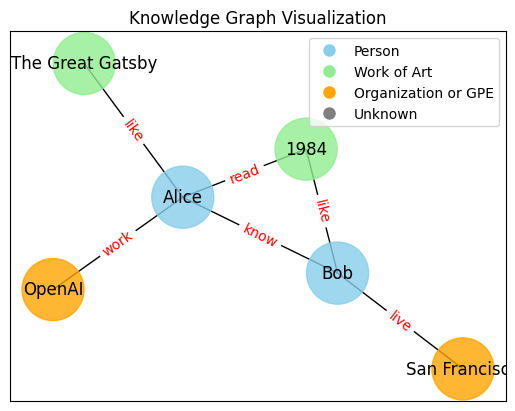

In [3]:
# Function to visualize the graph
def visualize_graph(G):
    pos = nx.spring_layout(G)  # Position nodes using the Fruchterman-Reingold force-directed algorithm

    # Node colors
    node_colors = []
    for node, data in G.nodes(data=True):
        if data['type'] == 'PERSON':
            node_colors.append('skyblue')
        elif data['type'] == 'WORK_OF_ART':
            node_colors.append('lightgreen')
        elif data['type'] in ['ORG', 'GPE']:
            node_colors.append('orange')
        else:
            node_colors.append('gray')

    # Draw nodes with colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    # Draw edge labels
    edge_labels = {(u, v): d['relationship'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Person', markersize=10, markerfacecolor='skyblue'),
        Line2D([0], [0], marker='o', color='w', label='Work of Art', markersize=10, markerfacecolor='lightgreen'),
        Line2D([0], [0], marker='o', color='w', label='Organization or GPE', markersize=10, markerfacecolor='orange'),
        Line2D([0], [0], marker='o', color='w', label='Unknown', markersize=10, markerfacecolor='gray'),
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Knowledge Graph Visualization")
    plt.show()

# Visualize the graph
visualize_graph(G)